# set 구분 들어간 매칭 파일에서 test set만 남기기

In [33]:
import os
import pandas as pd
import numpy as np
import pickle
import vitaldb
   
match_set = pd.read_csv('../../cranberry2/Preprocessing/match_20201125_set.csv')
match_set.replace({'set': {0: np.nan, 4: np.nan}},inplace=True) 
match_set.dropna(subset=['set'],inplace=True)
match_set['path']=[f_name.split('.')[0]+".csv" for f_name in match_set['path'].values.flatten()]
match_set.reset_index(inplace=True)
print(match_set)

     index  Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
0        3           3             3             146               146   
1       20          20            21             239               239   
2       21          21            22             240               240   
3       36          36            40             496               496   
4       40          40            44             545               545   
..     ...         ...           ...             ...               ...   
787   8346        8346          9025           45205             45205   
788   8363        8363          9042           45243             45243   
789   8364        8364          9043           45245             45245   
790   8373        8373          9052           45256             45256   
791   8380        8380          9059           45269             45269   

     Unnamed: 0.1.1.1.1       oID       hid gender   birthdate  \
0                   146  21884764  52067408  

In [23]:
setlist = match_set['path'].tolist()
setlist = np.array(setlist)
setlist = np.unique(setlist)
setlist = setlist.tolist()
print(len(setlist))

501


In [24]:
with open('../../cranberry2/Preprocessing/df_preop_match','rb') as f:
    a = pickle.load(f)
print(a)

           opid                  fileid                  file_path
0     190408044  A2_190408_103443.vital  PACU1_1_190408_115004.csv
1     190408106  E3_190408_180036.vital  PACU1_1_190408_202459.csv
2     190409012  A2_190409_073654.vital  PACU1_2_190409_110712.csv
3     190409044  D5_190409_101311.vital  PACU1_3_190409_114333.csv
4     190409057  F4_190409_105106.vital  PACU1_1_190409_133948.csv
...         ...                     ...                        ...
4109  201030106  R9_201030_145209.vital  PACU1_1_201030_161119.csv
4110  201030057  E6_201030_131959.vital  PACU1_3_201030_195639.csv
4111  201030082  R2_201030_185910.vital  PACU1_5_201030_203752.csv
4112  201030023  C4_201030_185047.vital  PACU1_1_201030_211816.csv
4113  201031004  R9_201031_084856.vital  PACU1_3_201031_131135.csv

[4114 rows x 3 columns]


# preop 계산

In [31]:
srate=250
path='../../cranberry2/Preprocessing/cache/peaks/ECG_250Hz_preop_2min/'
vpath = '../../cranberry2/Preprocessing/preop_vital/preop_vital/'
  
cnt = 0
for f in setlist:
    cnt +=1
    idlist = a[a['file_path']==f].index.tolist()
    if len(idlist) > 0:
        idx=idlist[0]
        a.loc[idx,'mean'] = np.nan
        a.loc[idx,'SSDN'] = np.nan
        a.loc[idx,'RMSSD'] = np.nan
        a.loc[idx,'test'] =1
        preop_path=a.loc[idx,'fileid']
        preop_peaks= preop_path[3:]
        try:
            peaks = pickle.load(open(path+preop_peaks, 'rb'))
            peaks=[peak for peak in peaks if peak < 2 *60*srate]
            #HR = vitaldb.vital_recs(vpath+preop_path, ['Solar8000/HR'], interval = 0.0025).flatten()[0:30000]
            RRi = [(peaks[i+1]-peaks[i])/srate for i in range(len(peaks)-1)]
            NNi = [y for y in RRi if 0.6<y<1.2]
            RMSSD = [NNi[i+1]-NNi[i] for i in range(len(NNi)-1)]
            RMSSD = np.array(RMSSD)
            NNi = np.array(NNi)
            if np.sum(NNi) < 2 * 60 * 0.9:
                print(cnt,' ',preop_path,' noise')
            else:                
                mean= np.mean(NNi)
                SSDN = np.std(NNi)
                RMSSD= np.std(RMSSD)
                a.loc[idx,'mean'] = mean
                a.loc[idx,'SSDN'] = SSDN
                a.loc[idx,'RMSSD'] = RMSSD
        except:
            print(preop_peaks,'error')
a.dropna(subset=['test'],inplace=True)
a.dropna(subset=['SSDN'],inplace=True)
print(a)
a.reset_index(inplace=True)
a.to_csv('HRV_preop_2min.csv')

3   D5_190723_120050.vital  noise
5   D1_190821_090009.vital  noise
21   R3_200521_161041.vital  noise
31   C4_200922_075059.vital  noise
35   C3_190718_093649.vital  noise
43   E1_200224_133655.vital  noise
52   R8_200731_074825.vital  noise
59   C1_190430_134735.vital  noise
63   D1_190822_080137.vital  noise
72   R3_200819_112640.vital  noise
75   A1_190419_110023.vital  noise
81   E6_190515_162052.vital  noise
83   D2_190529_075445.vital  noise
87   D1_190820_105343.vital  noise
122   C3_200611_143753.vital  noise
142   R7_201030_132821.vital  noise
143   A2_190409_073654.vital  noise
193   F2_190529_144941.vital  noise
197   A5_190717_004333.vital  noise
198   D5_190717_143419.vital  noise
221   C5_200215_083619.vital  noise
226   R10_200303_130705.vital  noise
235   D2_200528_075428.vital  noise
244   E1_200707_162828.vital  noise
251   D4_200724_132808.vital  noise
259   D3_200910_121128.vital  noise
305   R6_200623_125811.vital  noise
332   C3_190719_073653.vital  noise
349   D

# PACU 계산

In [34]:
import pickle
import vitaldb

srate=250
path='../../cranberry2/Preprocessing/cache/peaks/ECG_250Hz_pacu_2min/'

peak_files=[]
for root, dirs, files in os.walk(path):
    for file in files:
        peak_files.append(file)
#print(peak_files)

match_set['path']=[f_name.split('.')[0]+".vital" for f_name in match_set['path'].values.flatten()]
for j in range(len(match_set)):
    match_set.loc[j,'mean'] = np.nan
    match_set.loc[j,'SSDN'] = np.nan
    match_set.loc[j,'RMSSD']= np.nan

    pacu_peaks=  str(match_set.loc[j,'Value'])+','+str(match_set.loc[j,'index'])+','+ match_set.loc[j,'path']
    #print(pacu_peaks)
    try: 
        peaks = pickle.load(open(path+pacu_peaks, 'rb'))
        #print(peaks)
        RRi = [(peaks[i+1]-peaks[i])/srate for i in range(len(peaks)-1)]
        NNi = [y for y in RRi if 0.6<y<1.2]
        RMSSD = [NNi[i+1]-NNi[i] for i in range(len(NNi)-1)]
        RMSSD = np.array(RMSSD)
        NNi = np.array(NNi)
        if np.sum(NNi) < 2 * 60 * 0.9:
            print(preop_path,' noise')
        else:
            mean= np.mean(NNi)
            SSDN = np.std(NNi)
            RMSSD= np.std(RMSSD)
            match_set.loc[j,'mean'] = mean
            match_set.loc[j,'SSDN'] = SSDN
            match_set.loc[j,'RMSSD']= RMSSD

    except:
        print(j,'no peaks')
match_set.dropna(subset=['SSDN'],inplace=True)
#match_set.reset_index(inplace=True)
print(match_set)
match_set.to_csv('HRV_pacu_2min.csv')

R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
12 no peaks
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
53 no peaks
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116.vital  noise
R8_200924_080116

In [48]:
dics1 = {'path':match_set['path'],'mean':match_set['mean'],'SSDN':match_set['SSDN'],'RMSSD':match_set['RMSSD'],'NRS':match_set['Value']}
df1 = pd.DataFrame(dics1)
dics2 = {'path':a['file_path'],'mean':a['mean'],'SSDN':a['SSDN'],'RMSSD':a['RMSSD'],'NRS':0}
df2 = pd.DataFrame(dics2)
df2['path']=[f_name.split('.')[0]+".vital" for f_name in df2['path'].values.flatten()]

df = pd.concat([df1,df2])
df['NRS_bin'] = df['NRS']>=4
df['NRS_bin']=df['NRS_bin'].astype(int)
print(df)

df.to_csv('HRV_pacu_preop_2min_90%.csv')

                            path      mean      SSDN     RMSSD  NRS  NRS_bin
0    PACU1_2_190409_110712.vital  1.048889  0.044102  0.020046  4.0        1
1    PACU1_3_190410_023648.vital  1.048889  0.044102  0.020046  7.0        1
2    PACU1_3_190410_023648.vital  1.048889  0.044102  0.020046  5.0        1
3    PACU1_2_190412_122750.vital  1.048889  0.044102  0.020046  2.0        0
4    PACU1_3_190412_164430.vital  1.048889  0.044102  0.020046  5.0        1
..                           ...       ...       ...       ...  ...      ...
148  PACU1_7_201019_162425.vital  0.765615  0.043625  0.011446  0.0        0
149  PACU1_4_201019_163758.vital  0.853744  0.088286  0.072350  0.0        0
150  PACU1_7_201022_102105.vital  0.922844  0.082230  0.010781  0.0        0
151  PACU1_3_201029_175055.vital  0.945664  0.048870  0.046234  0.0        0
152  PACU1_2_201029_175450.vital  0.793040  0.025156  0.029047  0.0        0

[660 rows x 6 columns]


# AUROC 계산

[-0.02004631 -0.02004631 -0.02004631 -0.02004631 -0.02004631 -0.00451301
 -0.03890702 -0.06210415 -0.01280926 -0.0108538  -0.01720787 -0.02405292
 -0.00706261 -0.01170833 -0.01278277 -0.00483272 -0.00702226 -0.00555915
 -0.00739746 -0.00646284 -0.01837224 -0.00344877 -0.00523376 -0.00479011
 -0.03182878 -0.03353982 -0.04919307 -0.02899217 -0.00435825 -0.01041796
 -0.04614716 -0.00749789 -0.03109594 -0.01192996 -0.01467937 -0.03177696
 -0.05534811 -0.02930124 -0.01036697 -0.02242819 -0.03698264 -0.01422638
 -0.00481193 -0.00607241 -0.05528379 -0.05149311 -0.01339718 -0.00554368
 -0.00957185 -0.01342605 -0.02852552 -0.01324458 -0.01509525 -0.04602844
 -0.00970376 -0.01992648 -0.03748783 -0.03169159 -0.01212779 -0.00565987
 -0.01019242 -0.04813183 -0.02914826 -0.01496627 -0.01202148 -0.01396951
 -0.04559526 -0.00705712 -0.00718767 -0.02037961 -0.01115896 -0.00954014
 -0.0239295  -0.0366249  -0.03131167 -0.00413941 -0.12809859 -0.00956678
 -0.01463421 -0.07417688 -0.01316234 -0.01505912 -0

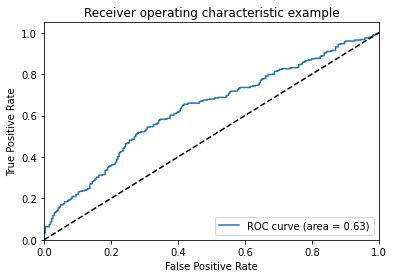

In [46]:
import numpy as np
from sklearn.metrics import roc_curve, auc, r2_score
import matplotlib.pyplot as plt

SSDN = np.array(df['RMSSD']) * (-1)
print(SSDN)
y1 = np.array(df['NRS_bin'])

false_positive_rate, true_positive_rate, threshold = roc_curve(y1, SSDN)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('SSDN test set auroc:', roc_auc)

plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

RMSSD test set AUROC: 0.6316096962963672
RMSSD test set AUPRC: 0.7284312446631401


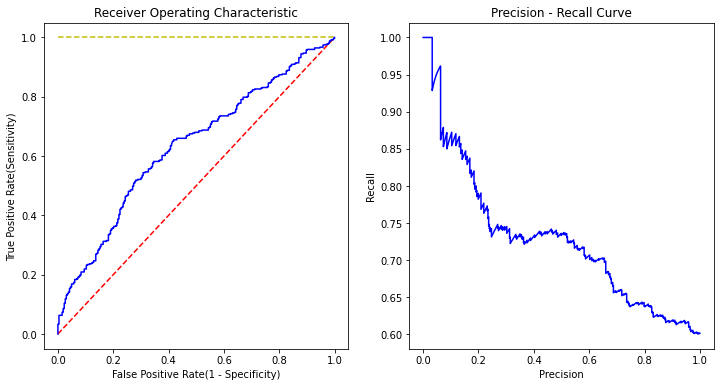

In [47]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt
'''
### Classification
# Model Accuracy of test set
model_y = y_pred>=0.5
acc_val = np.mean(model_y==y_test_bin)
print('test set accuracy:{:.2f}'.format(acc_val))
# Adding evaluation results to file name
test_path = 'output/preprocess3/input3-2_PPG+ECG/auroc{:.4f}_auprc{:.4f}_1D_CNN_{}acc{:.2f}'.format(roc_auc,prc_auc,model_name,acc_val)
os.rename(save_path, test_path)
'''

# moderate pain
false_positive_rate, true_positive_rate, threshold = roc_curve(y1, SSDN)
precision, recall, _ = precision_recall_curve(y1, SSDN)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('RMSSD test set AUROC:', roc_auc)
print('RMSSD test set AUPRC:', prc_auc)


# Plotting ROC, PRC
fig = plt.figure(figsize=(12,6))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - Recall Curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

#plt.savefig(test_path + '/roc_prc.png', bbox_inches="tight", pad_inches=0.5)